# import module

In [1]:
import os
gpu_number = "2"
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_number
from glob import glob

import tensorflow as tf
from tqdm import tqdm
import numpy as np
from tensorflow.keras import backend as keras_backend
import segmentation_models as sm

from src.data_loader.segmentation import SegDataloader

sm.set_framework ('tf.keras')

Segmentation Models: using `keras` framework.


In [2]:
gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from src.data_loader.segmentation import SegDataloader
from glob import glob

BACKBONE="inceptionv3"

task = "segmentation"
data_set_name = "camelyon_lymph_node_1024_remove_orange_peel"
batch_size = 16
on_memory = True
argumentation_proba = 0.8
preprocess_input = sm.get_preprocessing(BACKBONE)
target_size = (512,512)
interpolation = "bilinear"
dtype = "float32"


train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/train/image/*.png")
train_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/train/mask/*.png")

valid_image_path_list = glob(f"./datasets/{task}/{data_set_name}/valid/image/*.png")
valid_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/valid/mask/*.png")

test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/test/image/*.png")
test_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/test/mask/*.png")

train_data_loader = SegDataloader(image_path_list=train_image_path_list,
                                  mask_path_list=train_mask_path_list,
                                  batch_size=batch_size,
                                  on_memory=on_memory,
                                  argumentation_proba=argumentation_proba,
                                  preprocess_input=preprocess_input,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=True,
                                  dtype=dtype
                                  )
valid_data_loader = SegDataloader(image_path_list=valid_image_path_list,
                                  mask_path_list=valid_mask_path_list,
                                  batch_size=batch_size,
                                  on_memory=on_memory,
                                  argumentation_proba=0,
                                  preprocess_input=preprocess_input,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=True,
                                  dtype=dtype
                                  )
test_data_loader = SegDataloader(image_path_list=test_image_path_list,
                                 mask_path_list=test_mask_path_list,
                                 batch_size=1,
                                 on_memory=False,
                                 argumentation_proba=0,
                                 preprocess_input=preprocess_input,
                                 target_size=target_size,
                                 interpolation=interpolation,
                                 shuffle=False,
                                 dtype=dtype
                                 )

 [18514/18514] |############################################| (Time:  0:26:45) 
 [02/4628] |                                                | (ETA:   0:06:28) 

Total data num 18514


 [4628/4628] |##############################################| (Time:  0:06:23) 


Total data num 4628
Total data num 8007


In [4]:
# create the base pre-trained model~
model = sm.Unet(backbone_name=BACKBONE, input_shape=(
            None, None, 3), classes=1, activation='sigmoid')

In [5]:
from datetime import date

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Nadam

from src.util.custom_loss import PropotionalDiceLoss, TverskyLoss, dice_score, dice_loss, boundary_loss
from segmentation_models.losses import DiceLoss, BinaryFocalLoss

today = date.today()

# YY/MM/dd
today_str = today.strftime("%Y-%m-%d")
today_weight_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/weights/" 
today_logs_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/"
os.makedirs(today_weight_path, exist_ok=True)
os.makedirs(today_logs_path, exist_ok=True)
optimizer = Nadam(1e-4, clipnorm=1)

save_c = ModelCheckpoint(
    today_weight_path+"/weights_{val_loss:.4f}_{loss:.4f}_{epoch:02d}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='min')


reduceLROnPlat = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=20,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-7)
csv_logger = CSVLogger(f'{today_logs_path}/log.csv', append=False, separator=',')


model.compile(optimizer=optimizer, loss=PropotionalDiceLoss(include_focal=False, include_boundary=False), metrics=[dice_score])

In [ ]:
start_epoch = 0
epochs = 100

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger],
    initial_epoch=start_epoch
)

Epoch 1/100
1157/1157 [==============================] - 1104s 899ms/step - loss: 0.1021 - dice_score: 0.5311 - val_loss: 0.0723 - val_dice_score: 0.8266
Epoch 2/100
1157/1157 [==============================] - 1040s 898ms/step - loss: 0.0706 - dice_score: 0.6792 - val_loss: 0.0753 - val_dice_score: 0.6257
Epoch 3/100
1157/1157 [==============================] - 1039s 897ms/step - loss: 0.0642 - dice_score: 0.7049 - val_loss: 0.0579 - val_dice_score: 0.8326
Epoch 4/100
1157/1157 [==============================] - 1040s 899ms/step - loss: 0.0588 - dice_score: 0.7472 - val_loss: 0.0622 - val_dice_score: 0.7413
Epoch 5/100
1157/1157 [==============================] - 1042s 900ms/step - loss: 0.0551 - dice_score: 0.7724 - val_loss: 0.0532 - val_dice_score: 0.7875
Epoch 6/100
1157/1157 [==============================] - 1043s 900ms/step - loss: 0.0552 - dice_score: 0.7642 - val_loss: 0.0712 - val_dice_score: 0.8811
Epoch 7/100
1157/1157 [==============================] - 1040s 899ms/step - 

# Inference

ERROR! Session/line number was not unique in database. History logging moved to new session 66
['epoch', 'dice_score', 'loss', 'lr', 'val_dice_score', 'val_loss']
val_loss_min (epoch, loss, accuracy): (22, 0.0666, 0.9236)
val_dice_score_max (epoch, loss, accuracy): (51, 0.0776, 0.9454)
loss_score_diff_min (epoch, loss, accuracy): (25, 0.0769, 0.9405)


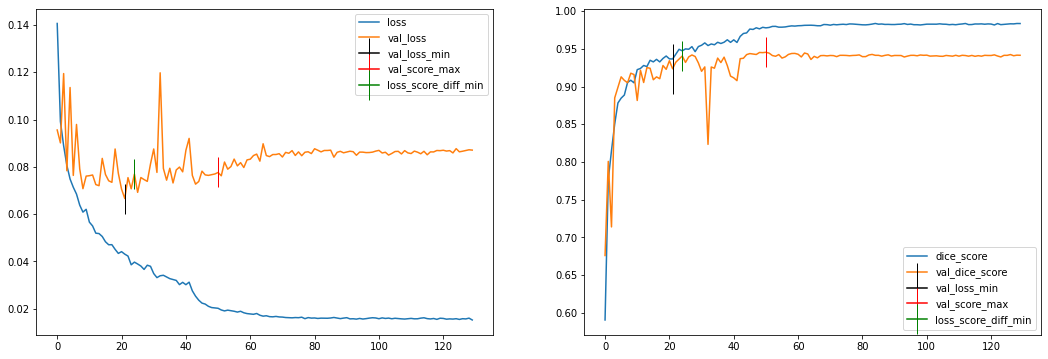

In [6]:
import csv
import shutil
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

result_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/"
result_weights = glob(f'{result_path}/weights/*')

with open(f'{result_path}/log.csv') as csv_file:
    reader = csv.DictReader(csv_file)
    dict_from_csv = {field_name:[] for field_name in reader.fieldnames}
    print(reader.fieldnames)
    for row in reader:
        for filedname in reader.fieldnames:
            dict_from_csv[filedname].append(float(row[filedname])) 

loss_min_epoch = np.argmin(dict_from_csv['val_loss']) + 1
loss_min_loss = np.min(dict_from_csv['val_loss'])
loss_min_accuracy = dict_from_csv['val_dice_score'][loss_min_epoch - 1]

score_max_epoch = np.argmax(dict_from_csv['val_dice_score']) + 1
score_max_loss = dict_from_csv['val_loss'][score_max_epoch - 1]
score_max_accuracy = np.max(dict_from_csv['val_dice_score'])

val_score = dict_from_csv['val_dice_score']
score_diff = np.maximum(np.array(dict_from_csv['dice_score'] - np.array(dict_from_csv['val_dice_score'])), 0)

loss_score_diff_min_epoch = np.argmax(val_score - score_diff) + 1
loss_score_diff_min_loss = dict_from_csv['val_loss'][loss_score_diff_min_epoch - 1]
loss_score_diff_min_accuracy = dict_from_csv['val_dice_score'][loss_score_diff_min_epoch - 1]

print(f"val_loss_min (epoch, loss, accuracy): ({loss_min_epoch}, {loss_min_loss:.4f}, {loss_min_accuracy:.4f})")
print(f"val_dice_score_max (epoch, loss, accuracy): ({score_max_epoch}, {score_max_loss:.4f}, {score_max_accuracy:.4f})")
print(f"loss_score_diff_min (epoch, loss, accuracy): ({loss_score_diff_min_epoch}, {loss_score_diff_min_loss:.4f}, {loss_score_diff_min_accuracy:.4f})")

_, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(dict_from_csv["loss"])
ax[0].plot(dict_from_csv["val_loss"])
ax[0].plot(loss_min_epoch - 1, loss_min_loss, marker="|", color="black", markersize=30)
ax[0].plot(score_max_epoch - 1, dict_from_csv['val_loss'][score_max_epoch - 1], marker="|", color="red", markersize=30)
ax[0].plot(loss_score_diff_min_epoch - 1, dict_from_csv['val_loss'][loss_score_diff_min_epoch - 1], marker="|", color="green", markersize=30)
ax[0].legend(["loss", "val_loss", "val_loss_min", "val_score_max", "loss_score_diff_min"])

ax[1].plot(dict_from_csv["dice_score"])
ax[1].plot(dict_from_csv["val_dice_score"])
ax[1].plot(loss_min_epoch - 1, dict_from_csv['val_dice_score'][loss_min_epoch - 1], marker="|", color="black", markersize=50)
ax[1].plot(score_max_epoch - 1, score_max_accuracy, marker="|", color="red", markersize=30)
ax[1].plot(loss_score_diff_min_epoch - 1, dict_from_csv['val_dice_score'][loss_score_diff_min_epoch - 1], marker="|", color="green", markersize=30)
ax[1].legend(["dice_score", "val_dice_score", "val_loss_min", "val_score_max", "loss_score_diff_min"])

plt.savefig(f"{result_path}/learning curve.png", dpi=300)
plt.show()
plt.close()


In [7]:
best_loss_path = glob(f"{result_path}/weights/weights_{loss_min_loss:.4f}_*.hdf5")[0]
shutil.copy(best_loss_path, f"{result_path}/epoch_{loss_min_epoch}_loss_{loss_min_loss:.4f}_dice_{loss_min_accuracy:.4f}.hdf5")
print(best_loss_path)

model.load_weights(best_loss_path)
model.evaluate(test_data_loader)

./result_daily/segmentation/camelyon_lymph_node_1024_remove_orange_peel/2021-08-08/gpu_2/target_size_(512, 512)//weights/weights_0.0666_0.0431_22.hdf5
8007/8007 [==============================] - 793s 99ms/step - loss: 0.1606 - dice_score: 0.8662


[0.16055415570735931, 0.8661738038063049]

In [8]:
best_score_path = glob(f"{result_path}/weights/*_{score_max_epoch:02d}.hdf5")[0]
shutil.copy(best_score_path, f"{result_path}/epoch_{score_max_epoch}_loss_{score_max_loss:.4f}_dice_{score_max_accuracy:.4f}.hdf5")
print(best_score_path)

model.load_weights(best_score_path)
model.evaluate(test_data_loader)

./result_daily/segmentation/camelyon_lymph_node_1024_remove_orange_peel/2021-08-08/gpu_2/target_size_(512, 512)//weights/weights_0.0776_0.0202_51.hdf5
8007/8007 [==============================] - 567s 71ms/step - loss: 0.1784 - dice_score: 0.8983


[0.1783691942691803, 0.8982516527175903]

In [9]:
best_diff_path = glob(f"{result_path}/weights/*_{loss_score_diff_min_epoch:02d}.hdf5")[0]
shutil.copy(best_diff_path, f"{result_path}/epoch_{loss_score_diff_min_epoch}_loss_{loss_score_diff_min_loss:.4f}_dice_{loss_score_diff_min_accuracy:.4f}.hdf5")
print(best_diff_path)

model.load_weights(best_diff_path)
model.evaluate(test_data_loader)

./result_daily/segmentation/camelyon_lymph_node_1024_remove_orange_peel/2021-08-08/gpu_2/target_size_(512, 512)//weights/weights_0.0769_0.0397_25.hdf5
8007/8007 [==============================] - 566s 70ms/step - loss: 0.2680 - dice_score: 0.8741


[0.26803019642829895, 0.8740746378898621]

In [44]:
from matplotlib import pyplot as plt

current_data_loader = train_data_loader
index = 16003
image_array, mask_array = current_data_loader.data_getter.data_on_memory_dict[index].values()
image_array = np.expand_dims(image_array, axis=0)
image_array = (image_array / 127.5) - 1

predicted_array = model.predict(image_array)[0,:,:,0]

image_array = (image_array + 1) * 127.5
image_array = image_array.astype("uint8")[0]

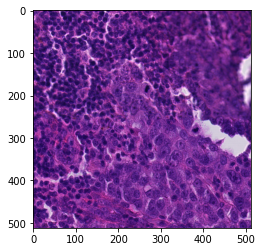

In [45]:
plt.imshow(image_array)

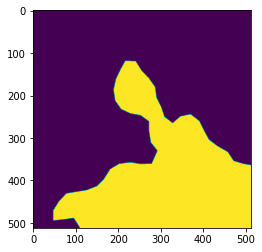

In [46]:
plt.imshow(mask_array)

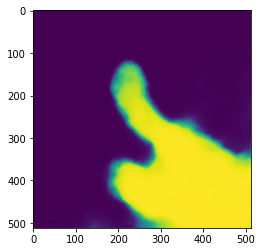

In [47]:
plt.imshow(predicted_array)

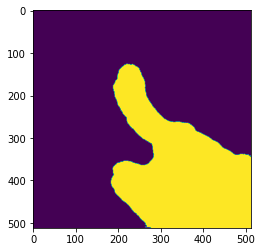

In [48]:
plt.imshow(predicted_array > 0.5)

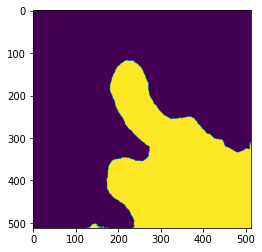

In [49]:
plt.imshow(predicted_array > 0.1)

# Unused Code

In [8]:
import csv

with open('./results/segmentation/glomerulus_0.65_1024_remove_peel_split_man/(512,512)/proportional_dice_focal_loss/blur/log.csv') as csv_file:
    reader = csv.DictReader(csv_file)
    dict_from_csv = {field_name:[] for field_name in reader.fieldnames}
    print(reader.fieldnames)
    for row in reader:
        for filedname in reader.fieldnames:
            dict_from_csv[filedname].append(float(row[filedname])) 

['epoch', 'dice_score', 'loss', 'lr', 'val_dice_score', 'val_loss']


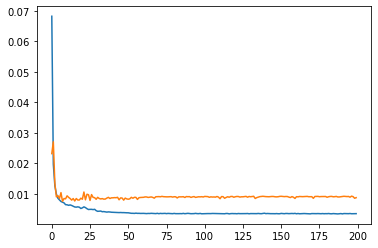

In [20]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["loss"])
plt.plot(dict_from_csv["val_loss"])
plt.show()

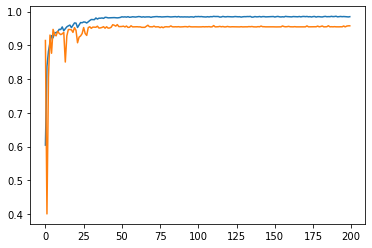

In [16]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["dice_score"])
plt.plot(dict_from_csv["val_dice_score"])
plt.show()